# Delta-Gamma Hedging

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [ ]:
def brownian_motion(mu, T, l):
    delta = T/l
    increments = np.zeros(l+1)
    increments[0] = 0
    increments[1:] = np.random.normal(mu, np.sqrt(delta), l)
    return np.cumsum(increments)

### Price trajectory - GBM

In [ ]:
def geom_brownian_motion(X_0, r, sigma, mu, T, l):
    ts = np.linspace(0, T, l)
    W = brownian_motion(mu, T, l)
    X_t = [0]*l
    for i in range(l):
        X_t[i] = X_0 * np.exp((r - (sigma**2)/2)*ts[i] + sigma * W[i])
    return X_t

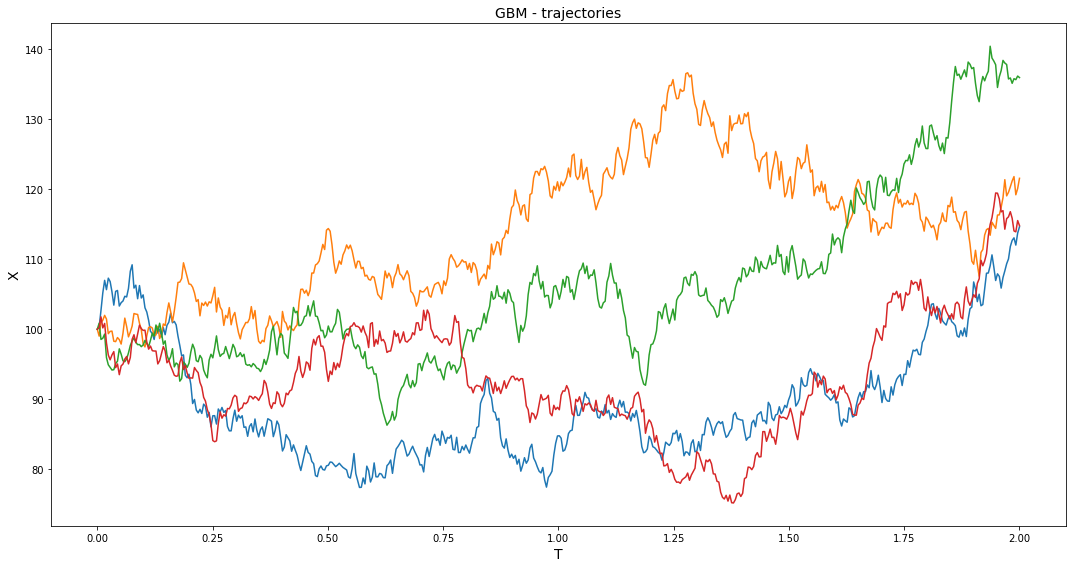

In [ ]:
T = 2
X_0 = 100
mu = 0
sigma = 0.2
r = 0.04
l = 252*T

plt.figure(figsize = (15,8))
time = np.linspace(0, T, l)
plt.plot(time, geom_brownian_motion(X_0, r, sigma, mu, T, l))
plt.plot(time, geom_brownian_motion(X_0, r, sigma, mu, T, l))
plt.plot(time, geom_brownian_motion(X_0, r, sigma, mu, T, l))
plt.plot(time, geom_brownian_motion(X_0, r, sigma, mu, T, l))
plt.title('GBM - trajectories', fontsize = 14)
plt.xlabel('T', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.tight_layout()
plt.show()

### Black-Scholes formula

In [ ]:
def payoff(X, K, call=True):
    if call:
        return max((X - K), 0) 
    else:
        return max((K - X), 0)

In [ ]:
def v_price(X, K, r, sigma, T, t, call=True):
    d_1 = (np.log(X / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d_2 = d_1 - sigma * np.sqrt(T - t)
    if call:
        price = X * stats.norm.cdf(d_1) - K * np.exp(-r * (T - t)) * stats.norm.cdf(d_2)
    else:
        price = K * np.exp(-r * (T-t)) * stats.norm.cdf(-d_2) - X * stats.norm.cdf(-d_1)

    return price

### Formula for $\Delta$

In [ ]:
def delta(X, K, r, sigma, T, t, call=True):
    d_1 = (np.log(X / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    if call:
        res = stats.norm.cdf(d_1)
    else:
        res = stats.norm.cdf(d_1) - 1
        
    return res

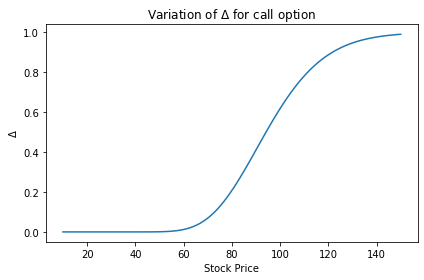

In [ ]:
#call
ts = np.linspace(10, 150, 100)
deltas = delta(ts, K = 100, T = 1, t = 0, r = 0.04, sigma = 0.2)

plt.plot(ts, deltas)
plt.xlabel('Stock Price')
plt.ylabel('$\Delta$')
plt.title('Variation of $\Delta$ for call option')
plt.tight_layout()
plt.show()

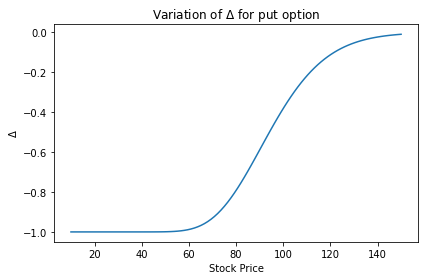

In [ ]:
#put
deltas_2 = delta(ts, K = 100, T = 1, t = 0, r = 0.04, sigma = 0.2, call=False)

plt.plot(ts, deltas_2)
plt.xlabel('Stock Price')
plt.ylabel('$\Delta$')
plt.title('Variation of $\Delta$ for put option')
plt.tight_layout()
plt.show()

### Formula for $\Gamma$

In [ ]:
def gamma(X, K, r, sigma, T, t):
    d_1 = (np.log(X / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    return stats.norm.pdf(d_1) / (X * sigma * np.sqrt(T - t))

# Hedging

## $\Delta$ hedging

In [ ]:
def delta_hedging(X_0, K, T, r, sigma, N, num_sim):
    
    hedging_costs = np.zeros(num_sim)
    for i in range(num_sim):
        X_t = geom_brownian_motion(X_0, r, sigma, T, N + 1)
        dt = T / N
        times = np.arange(0, T, dt)
        deltas = [delta(X_t[t], K, r, sigma, T, times[t]) for t in range(N)] # all deltas
        u_0 = deltas[0]
        v_0 = v_price(X_0, K, r, sigma, T, times[0]) # theoretical price at t=0
        money_borrowed = v_0 - X_0 * u_0        
        
        shares_to_buy = u_0
        bank_account = money_borrowed        
        for t in range(1, N): # time t
            shares_to_buy = deltas[t] - deltas[t-1]
            bank_account = np.exp(r * dt) * bank_account - shares_to_buy * X_t[t]
            
        # t=T
        bank_account = np.exp(r * dt) * bank_account
        payoff_value = payoff(X_t[-1], K)
        hedging_cost = np.exp(-r * T) * ((bank_account + deltas[-1] * X_t[-1] - payoff_value)) / v_0
    
        hedging_costs[i] = hedging_cost
        
    return hedging_costs

In [ ]:
X_0 = 100
r = 0.04
sigma = 0.2
T = 0.5
K = 110
num_sim = 10000

In [ ]:
delta_hedging_result_1 = delta_hedging(X_0, K, T, r, sigma, 1, num_sim)
delta_hedging_result_2 = delta_hedging(X_0, K, T, r, sigma, 2, num_sim)
delta_hedging_result_3 = delta_hedging(X_0, K, T, r, sigma, 4, num_sim)
delta_hedging_result_4 = delta_hedging(X_0, K, T, r, sigma, 10, num_sim)
delta_hedging_result_5 = delta_hedging(X_0, K, T, r, sigma, 20, num_sim)
delta_hedging_result_6 = delta_hedging(X_0, K, T, r, sigma, 100, num_sim)

## $\Delta-\Gamma$ hedging

In [ ]:
def delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, N, num_sims):
    
    delta_gamma_hedging_costs = np.zeros(num_sims)
    for i in range(num_sims):
        X_t = geom_brownian_motion(X_0, r, sigma, T, N + 1)
        dt = T / N
        times = np.arange(0, T, dt)
        
        v0_1 = v_price(X_0, K_1, r, sigma, T, times[0]) # premium at t=0 for strike price K_1 = 110
        v0_2 = v_price(X_0, K_2, r, sigma, T, times[0]) # premium at t=0 for strike price K_2 = 115
        v_t_K2 = [v_price(X_t[t], K_2, r, sigma, T, times[t]) for t in range(N)] # vt for K_2 = 115

        
        deltas_K_1 = [delta(X_t[t], K_1, r, sigma, T, times[t]) for t in range(N)] #all deltas for K_1
        gammas_K_1 = [gamma(X_t[t], K_2, r, sigma, T, times[t]) for t in range(N)] #all gammas for K_1
        deltas_K_2 = [delta(X_t[t], K_2, r, sigma, T, times[t]) for t in range(N)] #all deltas for K_2
        gammas_K_2 = [gamma(X_t[t], K_2, r, sigma, T, times[t]) for t in range(N)] #all gammas for K_2
        
        w0_2 = - gammas_K_1[0] / gammas_K_2[0] #amount of option 2
        w0_x = deltas_K_1[0] + w0_2 * deltas_K_2[0] #amount of the underlying
        m_0 = v0_1 + w0_2 * v0_2 - w0_x * X_0 #money needed
                
        wt_K2 = w0_2
        wt_x = w0_x
        m_t = m_0
        #time t
        for t in range(1, N):
            new_wt_K2 = - gammas_K_1[t] / gammas_K_2[t] #new amount of option 2
            new_wt_x = deltas_K_1[t] + new_wt_K2 * deltas_K_2[t] # new amount of the underlying
            m_t = np.exp(r*dt) * m_t + (new_wt_K2 - wt_K2) * v_t_K2[t] - (new_wt_x - wt_x) * X_t[t] # bank account
            
            wt_K2 = new_wt_K2 
            wt_x = new_wt_x
    
        #t=T
        m_t = np.exp(r*dt) * m_t
        payoff_K2 = payoff(X_t[-1], K_2)
        payoff_K1 = payoff(X_t[-1], K_1)
        delta_gamma_hedging_cost = np.exp(-r * T) * ((m_t + wt_x * X_t[-1] - payoff_K1 - wt_K2 * payoff_K2) / v0_1)

        delta_gamma_hedging_costs[i] = delta_gamma_hedging_cost
    
    return delta_gamma_hedging_costs

In [ ]:
X_0 = 100
r = 0.04
sigma = 0.2
T = 0.5
K_1 = 110
K_2 = 115
num_sims = 10000

In [ ]:
delta_gamma_hedging_result_1 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 1, num_sims)
delta_gamma_hedging_result_2 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 2, num_sims)
delta_gamma_hedging_result_3 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 4, num_sims)
delta_gamma_hedging_result_4 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 10, num_sims)
delta_gamma_hedging_result_5 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 20, num_sims)
delta_gamma_hedging_result_6 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 100, num_sims)

<ipython-input-25-1743378ee3c9>:28: RuntimeWarning: invalid value encountered in double_scalars
  new_wt_K2 = - gammas_K_1[t] / gammas_K_2[t] #new amount of option 2


## Plotting the final results for call option

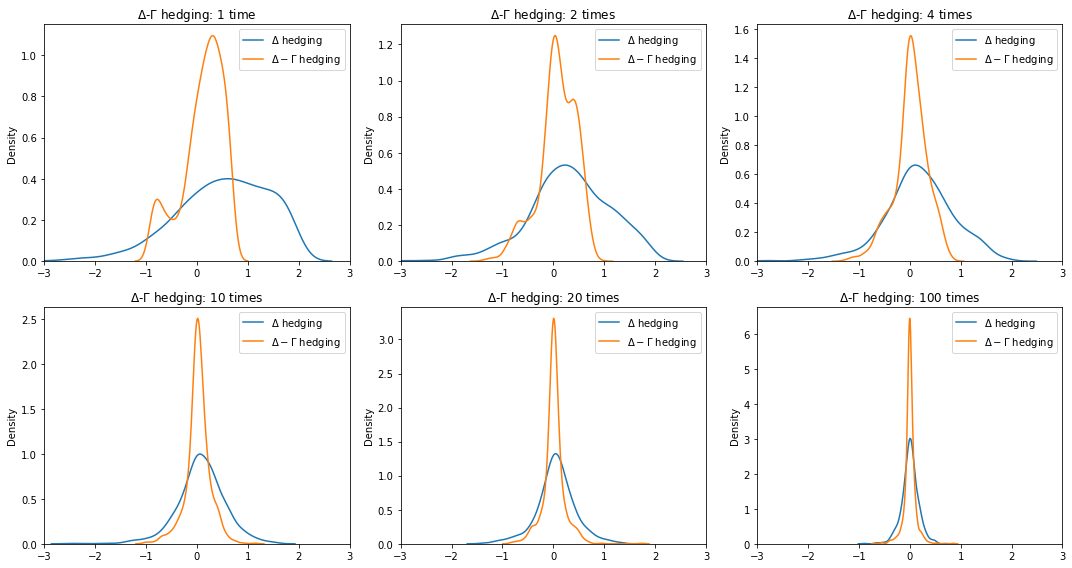

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes = axes.flatten()

data = [
    (delta_hedging_result_1, delta_gamma_hedging_result_1),
    (delta_hedging_result_2, delta_gamma_hedging_result_2),
    (delta_hedging_result_3, delta_gamma_hedging_result_3),
    (delta_hedging_result_4, delta_gamma_hedging_result_4),
    (delta_hedging_result_5, delta_gamma_hedging_result_5),
    (delta_hedging_result_6, delta_gamma_hedging_result_6)
]

labels = ['$\Delta$ hedging', '$\Delta-\Gamma$ hedging']

for i, (delta_hedging_result, delta_gamma_hedging_result) in enumerate(data):
    sns.kdeplot(x = delta_hedging_result, shade = False, label=labels[0], ax=axes[i])
    sns.kdeplot(x = delta_gamma_hedging_result, shade = False, label=labels[1], ax=axes[i])
    axes[i].set_xlim(-3, 3)
    axes[i].legend()
    axes[0].set_title('$\Delta$-$\Gamma$ hedging: 1 time')
    axes[1].set_title('$\Delta$-$\Gamma$ hedging: 2 times')
    axes[2].set_title('$\Delta$-$\Gamma$ hedging: 4 times')
    axes[3].set_title('$\Delta$-$\Gamma$ hedging: 10 times')
    axes[4].set_title('$\Delta$-$\Gamma$ hedging: 20 times')
    axes[5].set_title('$\Delta$-$\Gamma$ hedging: 100 times')

plt.tight_layout()
plt.show()

## Put option with K2 < K

In [ ]:
X_0 = 100
r = 0.04
sigma = 0.3
T = 0.5
K = 120
num_sim = 10000

In [ ]:
delta_hedging_result_1 = delta_hedging(X_0, K, T, r, sigma, 1, num_sim)
delta_hedging_result_2 = delta_hedging(X_0, K, T, r, sigma, 2, num_sim)
delta_hedging_result_3 = delta_hedging(X_0, K, T, r, sigma, 4, num_sim)
delta_hedging_result_4 = delta_hedging(X_0, K, T, r, sigma, 10, num_sim)
delta_hedging_result_5 = delta_hedging(X_0, K, T, r, sigma, 20, num_sim)
delta_hedging_result_6 = delta_hedging(X_0, K, T, r, sigma, 100, num_sim)

In [ ]:
X_0 = 100
r = 0.04
sigma = 0.3
T = 0.5
K_1 = 120
K_2 = 110
num_sims = 10000

In [ ]:
delta_gamma_hedging_result_1 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 1, num_sims)
delta_gamma_hedging_result_2 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 2, num_sims)
delta_gamma_hedging_result_3 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 4, num_sims)
delta_gamma_hedging_result_4 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 10, num_sims)
delta_gamma_hedging_result_5 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 20, num_sims)
delta_gamma_hedging_result_6 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 100, num_sims)

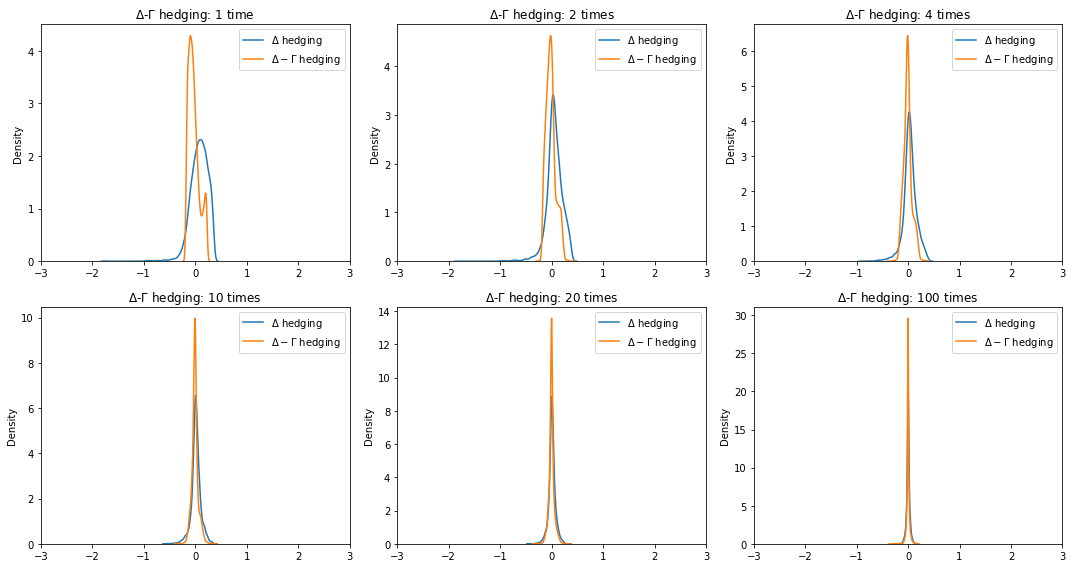

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes = axes.flatten()

data = [
    (delta_hedging_result_1, delta_gamma_hedging_result_1),
    (delta_hedging_result_2, delta_gamma_hedging_result_2),
    (delta_hedging_result_3, delta_gamma_hedging_result_3),
    (delta_hedging_result_4, delta_gamma_hedging_result_4),
    (delta_hedging_result_5, delta_gamma_hedging_result_5),
    (delta_hedging_result_6, delta_gamma_hedging_result_6)
]

labels = ['$\Delta$ hedging', '$\Delta-\Gamma$ hedging']

for i, (delta_hedging_result, delta_gamma_hedging_result) in enumerate(data):
    sns.kdeplot(x = delta_hedging_result, shade = False, label=labels[0], ax=axes[i])
    sns.kdeplot(x = delta_gamma_hedging_result, shade = False, label=labels[1], ax=axes[i])
    axes[i].set_xlim(-3, 3)
    axes[i].legend()
    axes[0].set_title('$\Delta$-$\Gamma$ hedging: 1 time')
    axes[1].set_title('$\Delta$-$\Gamma$ hedging: 2 times')
    axes[2].set_title('$\Delta$-$\Gamma$ hedging: 4 times')
    axes[3].set_title('$\Delta$-$\Gamma$ hedging: 10 times')
    axes[4].set_title('$\Delta$-$\Gamma$ hedging: 20 times')
    axes[5].set_title('$\Delta$-$\Gamma$ hedging: 100 times')

plt.tight_layout()
plt.show()

## Call with $K < X_{0}$ and $K_{2} = X_{0}$ 

In [ ]:
X_0 = 100
r = 0.05
sigma = 0.3
T = 1
K = 90
num_sim = 10000

In [ ]:
%%time

delta_hedging_result_1 = delta_hedging(X_0, K, T, r, sigma, 1, num_sim)
delta_hedging_result_2 = delta_hedging(X_0, K, T, r, sigma, 2, num_sim)
delta_hedging_result_3 = delta_hedging(X_0, K, T, r, sigma, 4, num_sim)
delta_hedging_result_4 = delta_hedging(X_0, K, T, r, sigma, 10, num_sim)
delta_hedging_result_5 = delta_hedging(X_0, K, T, r, sigma, 20, num_sim)
delta_hedging_result_6 = delta_hedging(X_0, K, T, r, sigma, 100, num_sim)

Wall time: 2min 10s


In [ ]:
X_0 = 100
r = 0.05
sigma = 0.3
T = 1
K_1 = 90
K_2 = 100
num_sims = 10000

In [ ]:
%%time

delta_gamma_hedging_result_1 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 1, num_sims)
delta_gamma_hedging_result_2 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 2, num_sims)
delta_gamma_hedging_result_3 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 4, num_sims)
delta_gamma_hedging_result_4 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 10, num_sims)
delta_gamma_hedging_result_5 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 20, num_sims)
delta_gamma_hedging_result_6 = delta_gamma_hedging(X_0, K_1, K_2, T, r, sigma, 100, num_sims)

<ipython-input-31-4eb452e92981>:28: RuntimeWarning: invalid value encountered in double_scalars
  new_wt_K2 = - gammas_K_1[t] / gammas_K_2[t] #new amount of option 2


Wall time: 13min 23s


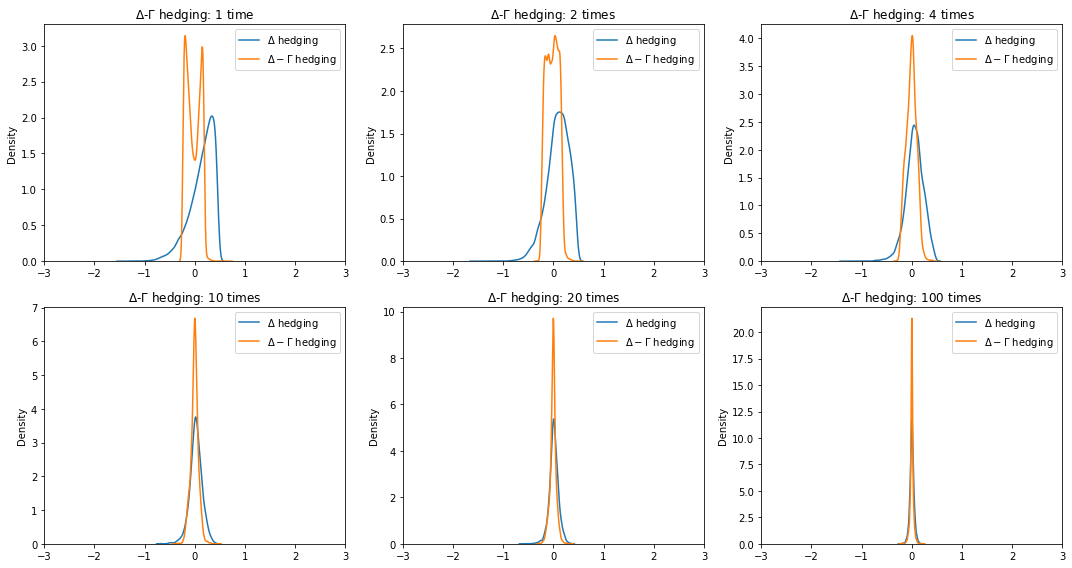

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes = axes.flatten()

data = [
    (delta_hedging_result_1, delta_gamma_hedging_result_1),
    (delta_hedging_result_2, delta_gamma_hedging_result_2),
    (delta_hedging_result_3, delta_gamma_hedging_result_3),
    (delta_hedging_result_4, delta_gamma_hedging_result_4),
    (delta_hedging_result_5, delta_gamma_hedging_result_5),
    (delta_hedging_result_6, delta_gamma_hedging_result_6)
]

labels = ['$\Delta$ hedging', '$\Delta-\Gamma$ hedging']

for i, (delta_hedging_result, delta_gamma_hedging_result) in enumerate(data):
    sns.kdeplot(x = delta_hedging_result, shade = False, label=labels[0], ax=axes[i])
    sns.kdeplot(x = delta_gamma_hedging_result, shade = False, label=labels[1], ax=axes[i])
    axes[i].set_xlim(-3, 3)
    axes[i].legend()
    axes[0].set_title('$\Delta$-$\Gamma$ hedging: 1 time')
    axes[1].set_title('$\Delta$-$\Gamma$ hedging: 2 times')
    axes[2].set_title('$\Delta$-$\Gamma$ hedging: 4 times')
    axes[3].set_title('$\Delta$-$\Gamma$ hedging: 10 times')
    axes[4].set_title('$\Delta$-$\Gamma$ hedging: 20 times')
    axes[5].set_title('$\Delta$-$\Gamma$ hedging: 100 times')

plt.tight_layout()
plt.show()